In [3]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [4]:
dataset = pd.read_csv('hist_ECCs.csv', index_col=0)
print(dataset.shape)
dataset.head()

(5182, 258)


,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,roi_label,grade
0,0,0,0,0,0,0,0,0,0,0,...,-3,0,1,1,1,1,1,1,1_1,3
1,0,0,0,0,0,0,0,0,0,0,...,-14,-9,-5,-2,0,0,0,1,1_2,3
2,0,0,0,0,0,0,0,0,0,0,...,-2,0,1,1,1,1,1,1,1_3,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1_4,3
4,0,0,0,0,0,0,0,0,0,0,...,-4,-1,0,0,1,1,1,1,1_5,3


In [5]:
X = dataset[[str(i) for i in range(256)]].values
print(X.shape)

(5182, 256)


In [6]:
y = dataset.grade.values
print(y.shape)

print(pd.value_counts(y))

(5182,)
3    2567
4    2351
5     264
dtype: int64


In [7]:
X_no5 = X[y != 5]
y_no5 = y[y != 5]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_no5, y_no5, test_size=0.2, random_state=42)

## rbf kernel

In [9]:
%%time
clf = svm.SVC(kernel='rbf', 
              class_weight='balanced', 
              C=1,
              random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 1.17 s, sys: 16 ms, total: 1.18 s
Wall time: 1.19 s


0.8567073170731707

In [10]:
acc = []

for i in tqdm(range(100)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_no5, y_no5, test_size=0.2, random_state=i)
    
    clf = svm.SVC(kernel='rbf', 
              class_weight='balanced', 
              C=1,
              random_state=42).fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))
    
print(np.mean(acc))

  0%|          | 0/100 [00:00<?, ?it/s]

0.8497459349593497


In [24]:
print(np.std(acc))

0.009545680369433126


0.8567073170731707


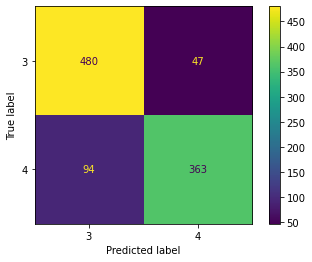

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_no5, y_no5, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='rbf', 
              class_weight='balanced', 
              C=1,
              random_state=42).fit(X_train, y_train)
print(clf.score(X_test, y_test))


predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.savefig('raw_ecc_confusion.pdf')
plt.show()

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train, test in tqdm(skf.split(X_no5, y_no5)):
    #print(pd.value_counts(y[train]).values, pd.value_counts(y[test]).values )
    clf = svm.SVC(kernel='rbf', 
              class_weight='balanced', 
              C=1,
              random_state=42).fit(X[train], y[train])
    print(clf.score(X[test], y[test]))

0it [00:00, ?it/s]

0.8191056910569106
0.8130081300813008
0.8140243902439024
0.8168870803662258
0.8046795523906409


In [15]:
from sklearn import tree

for train, test in tqdm(skf.split(X, y)):
    #print(pd.value_counts(y[train]).values, pd.value_counts(y[test]).values )
    clf = tree.DecisionTreeClassifier().fit(X[train], y[train])
    print(clf.score(X[test], y[test]))

0it [00:00, ?it/s]

[2053 1881  211] [514 470  53]
0.8254580520732884
[2053 1881  211] [514 470  53]
0.8341369334619093
[2054 1880  212] [513 471  52]
0.8252895752895753
[2054 1881  211] [513 470  53]
0.8185328185328186
[2054 1881  211] [513 470  53]
0.8359073359073359


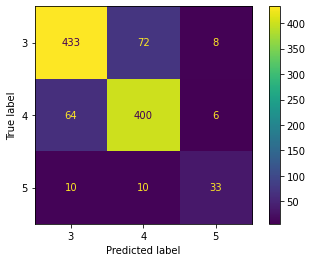

In [16]:
predictions = clf.predict(X[test])
cm = confusion_matrix(y[test], predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

### custom kernel with l1 norm

In [15]:
X_matrix_test = np.zeros((len(X_train), len(X_train)))

for i in tqdm(range(len(X_train))):
    for j in range(i+1, len(X_train)):
        X_matrix_test[i,j] = np.sum(abs(X_train[i] - X_train[j]))
        X_matrix_test[j,i] = X_matrix_test[i,j]
        
print(X_matrix_test.shape)

  0%|          | 0/3109 [00:00<?, ?it/s]

(3109, 3109)


In [16]:
%%time
clf = svm.SVC(kernel='precomputed', 
              class_weight='balanced', 
              C=1, 
              random_state=42).fit(X_matrix_test, y_train)

CPU times: user 311 ms, sys: 22.1 ms, total: 333 ms
Wall time: 669 ms


In [17]:
X_matrix_test_train = np.zeros((len(X_test), len(X_train)))

for i in tqdm(range(len(X_test))):
    for j in range(len(X_train)):
        X_matrix_test_train[i,j] = np.sum(abs(X_train[i] - X_train[j]))
        
print(X_matrix_test_train.shape)

  0%|          | 0/2073 [00:00<?, ?it/s]

(2073, 3109)


In [18]:
clf.score(X_matrix_test_train, y_test)

0.3154848046309696

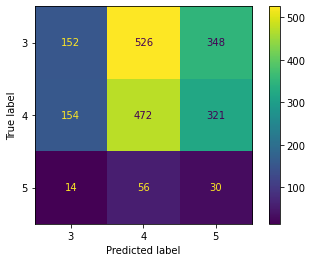

In [19]:
predictions = clf.predict(X_matrix_test_train)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()